In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf

In [177]:
# --- 1. Data Generation (Hypothetical Series A, B, C) ---
# Goal: Create series with varying residual predictability.
np.random.seed(42)
index = pd.date_range(start='2020-01-01', periods=120, freq='MS')
T = np.linspace(10, 20, 120)  # Strong Trend
S = 2 * np.sin(2 * np.pi * np.arange(120) / 12)  # Clear Seasonality (Period 12)

# Series A: Low Residual Noise (Highly Predictable)
R_A = np.random.normal(0, 0.2, 120)
Series_A = pd.Series(T + S + R_A, index=index)

# Series B: Moderate Residual Noise (Moderately Predictable)
# Residual is larger and has slight autocorrelation (e.g., small AR(1) process)
R_B = np.random.normal(0, 0.8, 120) + 0.3 * np.random.normal(0, 1, 120)
Series_B = pd.Series(T + 0.5 * S + R_B, index=index)

# Series C: High Residual Noise / Volatility (Low Predictability)
# Large, high-frequency noise that can flip the T+S sign
R_C = np.random.normal(0, 5, 120)
Series_C = pd.Series(T * 0.5 + R_C, index=index) # Weaker Trend & Seasonality
Series_C.iloc[60:70] += 5 # Introduce an outlier cluster

data = pd.DataFrame({'A': Series_A, 'B': Series_B, 'C': Series_C})

In [178]:
# --- 2. STL Decomposition and Metric Calculation ---
period = 12
results = {}
for name, series in data.items():
    # Perform STL decomposition (using robust=True for better outlier handling)
    # The seasonal window is set to 'periodic' for a fixed seasonal pattern,
    # but can be a number (e.g., 13) for a smoother, evolving seasonal component.
    stl = STL(series, period=period, robust=True)
    res = stl.fit()

    # Extract the Residual component (Rt)
    R_t = res.resid

    # METRIC 1: Autocorrelation of Residuals at Lag 1 (ACF(Rt) @ 1)
    # Near 0 means white noise (unpredictable noise), suggesting T+S is stable.
    # Higher value means structured noise (potential predictability remaining).
    acf_lag1 = acf(R_t.dropna(), nlags=1)[1]

    # METRIC 2: Residual Sign Change Frequency
    # A high frequency means the noise rapidly reverses, which can easily
    # overwhelm and flip the combined (T+S) forecast sign.
    sign_changes = np.sum(np.sign(R_t).diff().fillna(0) != 0)
    sign_change_freq = sign_changes / len(R_t.dropna())

    results[name] = {
        'ACF_R_t_Lag1': round(acf_lag1, 4),
        'Residual_Sign_Flips': round(sign_change_freq, 4)
    }

In [179]:
# --- 3. Output Comparison Table ---
comparison_df = pd.DataFrame(results).T
print("--- STL Residual Sign Predictability Metrics ---\n")
comparison_df.sort_values(by='Residual_Sign_Flips')

--- STL Residual Sign Predictability Metrics ---



,ACF_R_t_Lag1,Residual_Sign_Flips
A,-0.0766,0.5417
B,-0.2293,0.5667
C,0.0347,0.6333


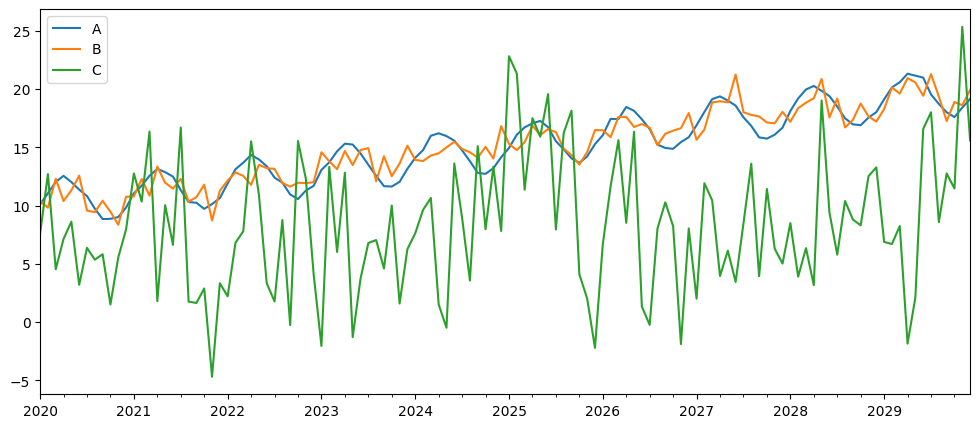

In [172]:
data.plot(figsize=(12,5));

In [190]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for name, series in data.items():
    # Perform STL decomposition (using robust=True for better outlier handling)
    # The seasonal window is set to 'periodic' for a fixed seasonal pattern,
    # but can be a number (e.g., 13) for a smoother, evolving seasonal component.
    stl = STL(series, period=period, robust=True)
    res = stl.fit()

    # Extract the Residual component (Rt)
    R_t = res.resid
    print(f' Series {name}\n, {acorr_ljungbox(R_t.dropna(), lags=1)}\n')
    print('---')

 Series A
,     lb_stat  lb_pvalue
1  0.721185   0.395755

---
 Series B
,     lb_stat  lb_pvalue
1  6.465862   0.010997

---
 Series C
,     lb_stat  lb_pvalue
1  0.147944   0.700508

---
